In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from autoplan.trainer import ParserTrainer, ClassEvaluation
from autoplan.token import OCamlTokenizer
from autoplan.vis import plot_accuracy, plot_cm, plot_loss
from autoplan.dataset import TrainVal, RandomSplit, build_synthetic_dataset, set_random_seed
from autoplan.generator import ProgramGenerator
from grammars.rainfall.ocaml import Program, Labels
from autoplan.parsing import ProgramParser
from autoplan.neighbors import TokenNNClassifier

from tqdm.auto import tqdm
from scripts.rainfall_ingest import load_full_t1, ingest_dataset, load_new_labels
import torch
import seaborn as sns
from iterextras import par_for
from pickle_cache import PickleCache
from torch import nn
import numpy as np
import dataclasses
import os

pcache = PickleCache()
device = torch.device('cuda:7')

In [4]:
set_random_seed(0)

In [5]:
known_student_dataset = ingest_dataset('T1')
unknown_student_dataset = load_new_labels(known_student_dataset.vocab_index)

Skipped 16 programs


In [ ]:
# for item in known_student_dataset.dataset:
#     if item['labels'].item() == 2:
#         print(item['source'])
#         print(item['countwhere'])
#         print('='*30 + '\n\n')

In [62]:
synthetic_dataset = pcache.get('synth_ocaml_data', lambda: build_synthetic_dataset(
    label_set=Labels, 
    N=1000, 
    tokenizer=OCamlTokenizer(), 
    generator=ProgramGenerator(Program()),
    vocab_index=known_student_dataset.vocab_index,
    unique=True),
    force=True)

In [7]:
ds = synthetic_dataset
name_order = sorted(ds.choices.keys(), key=lambda name: ds.choice_indices[name])
for item in synthetic_dataset.dataset:
    for c in item['trace']:
        name = name_order[c.item()]
        if item['choices'][c] >= len(ds.choices[name]):
            raise Exception(name)        

In [63]:
def student_eval(trainer, cfg):
    trainer.model.save('parser.pt')
    parser = ProgramParser(Program(), synthetic_dataset, 'parser.pt', device=device, model_opts=cfg)
        
    def ds_eval(ds):
        pred = []
        true = []
        progs = []
        parses = []
        for batch in ds.loader(ds.dataset):
                for i in range(len(batch['program'])):
                    pred_prog, pred_parse = parser.infer(
                        batch['program'][i].unsqueeze(0), batch['program_len'][i].unsqueeze(0))
                    pred.append(int(pred_parse['strategy'][1]))
                    parses.append(pred_parse)
                    true.append(batch['labels'][i].item())
                    progs.append(pred_prog)
        return progs, ClassEvaluation.from_preds(true, pred, ['Clean First', 'Clean in SC', 'Single Loop']), parses
    
    return ds_eval(known_student_dataset), ds_eval(unknown_student_dataset)

In [64]:
configs = [
    {
        'model': nn.LSTM,
        'embedding_size': 128,
        'hidden_size': 512
    },
    {
        'model': nn.GRU,
        'embedding_size': 128,
        'hidden_size': 512
    },
    {
        'model': nn.LSTM,
        'embedding_size': 512,
        'hidden_size': 512
    },
    {
        'model': nn.LSTM,
        'embedding_size': 1024,
        'hidden_size': 1024,
    },
    {
        'model': nn.LSTM,
        'embedding_size': 128,
        'hidden_size': 128,
    },
    {
        'model': nn.LSTM,
        'embedding_size': 512,
        'hidden_size': 128,
    }
]

model_opts = {
    'model': nn.LSTM,
    'embedding_size': 128,
    'hidden_size': 512
}

In [75]:
def run_config(ci, cfg):
    set_random_seed(0)
    
    trainer = ParserTrainer(
        synthetic_dataset, 
        split=RandomSplit(synthetic_dataset), 
        device=device, 
        model_opts=cfg, 
        val_frac=0.05,
        optim_opts={'lr': 1e-3})
    
    losses = [] 
    train_eval = [] 
    val_eval = []
    kno_eval = []
    kno_progs = []
    unk_eval = []
    unk_progs = []

    for i in tqdm(range(250)):
        loss = trainer.train_one_epoch()
        losses.append(loss)
        train, val = trainer.eval()
        train_eval.append(train)
        val_eval.append(val)
        (kno_prog, kno, _1), (unk_prog, unk, _2) = student_eval(trainer, cfg)
        kno_eval.append(kno)
        kno_progs.append(kno_prog)
        unk_eval.append(unk)
        unk_progs.append(unk_prog)
        if i % 5 == 0:
            trainer.model.save(os.path.expanduser('~/autoplan/data/rainfall/models/cfg{}_epoch{}.pt'.format(ci, i)))
        
    return losses, train_eval, val_eval, kno_eval, kno_progs, unk_eval, unk_progs

In [ ]:
#all_results = []
for i, cfg in enumerate(configs[1:]):
    all_results.append(run_config(i, cfg))

In [ ]:
sorted([
    (configs[i], max([evl.accuracy for evl in res[5]]))
    for i, res in enumerate(all_results)
], key=lambda t: -t[1])


In [76]:
final_result = run_config(10, model_opts)

In [89]:
model_opts

{'model': torch.nn.modules.rnn.LSTM, 'embedding_size': 128, 'hidden_size': 512}

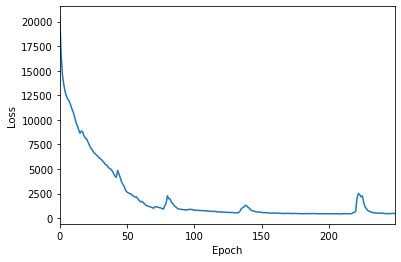

In [77]:
losses, train_eval, val_eval, kno_eval, kno_progs, unk_eval, unk_progs = final_result #all_results[2]
plot_loss(losses)

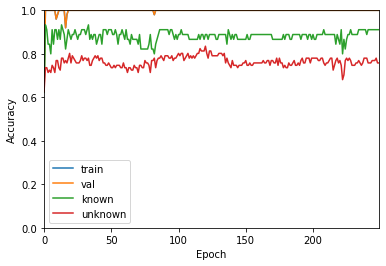

In [78]:
ax = plot_accuracy([t['strategy'] for t in train_eval], label='train')
plot_accuracy([t['strategy'] for t in val_eval], ax=ax, label='val')
plot_accuracy(kno_eval, ax=ax, label='known')
plot_accuracy(unk_eval, ax=ax, label='unknown')
ax.legend()

In [79]:
best_kno_eval = kno_eval[np.argmax([evl.accuracy for evl in kno_eval])]
best_unk_eval = unk_eval[np.argmax([evl.accuracy for evl in unk_eval])]

best_kno_eval.print_incorrect(known_student_dataset)

Program 19:
let rec stop (aloi : int list) =
  (match aloi with
   | [] -> []
   | hd::tl -> if hd = (-999) then [] else hd :: (stop tl) : int list)
let rec non_negative_average (aloi : int list) =
  (let average (alon : int list) =
     (match alon with
      | [] -> 0.0
      | _::_ ->
          (float_of_int (List.fold_right (+) alon 0)) /.
            (float_of_int (List.length alon)) : float) in
   average (List.filter (fun x -> x >= 0) aloi) : float)
let rec rainfall (aloi : int list) =
  (match aloi with | [] -> 0.0 | hd::tl -> non_negative_average (stop aloi) : 
  float)

Pred: GeneralRainfallLabels.CleanInSC
True: GeneralRainfallLabels.CleanFirst

Program 20:
let rainfall (alon : int list) =
  (let rec rainfallHelp (alon : int list) (nlon : int list) =
     (match alon with
      | [] ->
          (List.fold_right (fun x -> fun y -> x + y) nlon 0) /
            (List.length nlon)
      | hd::tl ->
          (match hd with
           | (-999) ->
               if (List.length n

In [82]:
np.argmax([evl.accuracy for evl in unk_eval])

120

In [86]:
best_config = os.path.expanduser('~/autoplan/data/rainfall/models/cfg{}_epoch{}.pt'.format(10, 120))

In [87]:
best_config

'/home/wcrichto/autoplan/data/rainfall/models/cfg10_epoch120.pt'

In [85]:
best_eval = unk_eval[np.argmax([evl.accuracy for evl in unk_eval])]
pcache.set('parser_best_eval', best_eval)

PicklingError: Can't pickle <class 'autoplan.trainer.ClassEvaluation'>: it's not the same object as autoplan.trainer.ClassEvaluation

Accuracy: 0.9333333333333333


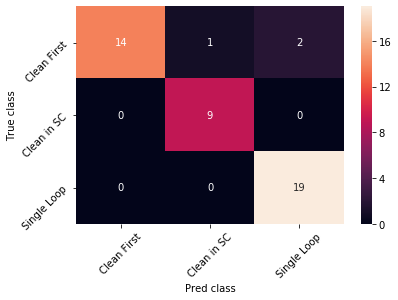

In [80]:
print('Accuracy:', best_kno_eval.accuracy)
best_kno_eval.plot_cm(normalize=False)

Accuracy 0.8351648351648352


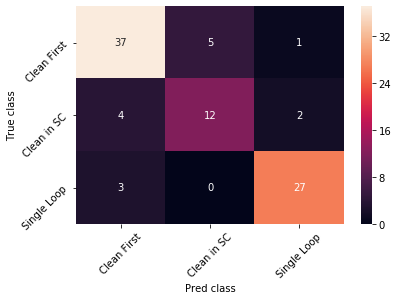

In [81]:
print('Accuracy', best_unk_eval.accuracy)
best_unk_eval.plot_cm(normalize=False)

In [ ]:
(kno_progs2, kno_eval2, kno_parses), _ = student_eval(trainer)

In [ ]:
for i in kno_eval2.incorrect():
    print('Pred: {}\nTrue: {}\n'.format(str(Labels(kno_eval2.pred[i])), str(Labels(kno_eval2.true[i]))))
    print(known_student_dataset.dataset[i]['source'])
    print('='*30)
    print(OCamlTokenizer().tokenize(kno_progs2[i])[1])
    print('\n\n\n')

In [ ]:
list(possible_choices.items())

In [ ]:
def featurize_parse_onehot(parse):
    possible_choices = synthetic_dataset.choices
    
    all_enc = []
    for k, v in possible_choices.items():
        onehot = np.zeros(len(v))
        if k in parse:
            onehot[parse[k][0]] = 1            
        all_enc.append(onehot)           

    return np.hstack(all_enc)

def featurize_parse_ordinal(parse):
    possible_choices = synthetic_dataset.choices
    
    feat = np.full(len(possible_choices), -1)
    for i, (k, v) in enumerate(possible_choices.items()):
        if k in parse:
            feat[i] = parse[k][0]
    return feat

In [ ]:
kno_parses[28]

In [ ]:
from iterextras import unzip
X, Y = unzip([
    (featurize_parse_onehot(parse), int(CountWhere.from_string(item['countwhere'])))
    for parse, item in zip(kno_parses, known_student_dataset.dataset)
])

In [ ]:
from iterextras import unzip
Xord, Y = unzip([
    (featurize_parse_ordinal(parse), int(CountWhere.from_string(item['countwhere'])))
    for parse, item in zip(kno_parses, known_student_dataset.dataset)
])

In [ ]:
import json
pcache.set('xparse', json.loads(json.dumps(kno_parses)))

In [ ]:
pcache.set('xordy', (Xord, Y))

In [ ]:
from sklearn import tree, svm
from sklearn.model_selection import cross_val_score

clf = svm.SVC()
clf = tree.DecisionTreeClassifier()
np.mean(cross_val_score(clf, X, Y, cv=10))